**Ho Chi Minh City University of Technology**

**Instructor:** Tran Van Hoai 

**List of Student:**



1.   Nguyen Anh Van - 1915886
2.   Nguyen Quoc Trong - 1915676
3.   Nguyen Quoc Hung - 1913610
4.   Le Mau Phuc Khang - 1913693



**MM1 queue with reneging**

**Install Simpy if it is not availble**

In [1]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import of required modules**

In [2]:
import csv
import simpy
import random
import numpy as np
# import numpy.random as random
from enum import Enum


### Simulation parameters


*   ARRIVAL_RATE is lambda
*   SERVICE_RATE is muy



In [3]:
SIMULATION_TIME = 20
CAPACITY = 1
ARRIVAL_RATE = 7.5 
SERVICE_RATE = 8.0 
RENEGING = True
WITHOUT_RENEGING = False
PATIENT_TIME = 1.0

PLOT_STATISTICS = True
PLOT_MAX_TIME = 100
WRITE_EVENTS_TO_CSV = True

## Discrete-Event Simulation model

**The definition of a customer**.

The properties of a customer are


1. customer_id
2. patient_time: the maximum time customer waiting for service

In [4]:
class Customer:
    def __init__(self, id: int, patient_time: float = None):
        self.id = id
        self.patient_time = patient_time

## The Event Type

**There are for event type**


1.   Arrival: Customer come for serving 
2.   Serving: Customer is served
3.   Completion: Customer is out of server
4.   Reneging: The waiting time is more than patient time, customer go out



In [5]:
class EventType(Enum):
    ARRIVAL = 'ARRIVAL'
    SERVING = 'SERVING'
    COMPLETION = 'COMPLETION'
    RENEGING = 'RENEGING'

## Tracking data from simulation


**We have two class tracking data in order to compare m/m/1 queue and m/m/1 queue with reneging**



1. Tracking data from m/m/1 queue

In [6]:
class WithoutRenegingTracker:

    def __init__(self):
        self.event_history = list()
        self.total_waiting_time = 0.0
        self.total_completed_waiting_time = 0.0
        self.total_reneged_waiting_time = 0.0
        self.total_service_time = 0.0
        self.total_response_time = 0.0

    def record_arrival_event(self, time: float, customer_id: int, resource: simpy.Resource):
        self.event_history.append({
            'time': time,
            'type': EventType.ARRIVAL.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })

    def record_serving_event(self, time: float, customer_id: int, resource: simpy.Resource):
        self.event_history.append({
            'time': time,
            'type': EventType.SERVING.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })

    def record_completion_event(self, time: float, customer_id: int, resource: simpy.Resource, waiting_time: float, service_time: float):
        self.event_history.append({
            'time': time,
            'type': EventType.COMPLETION.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })
        self.total_waiting_time += waiting_time
        self.total_completed_waiting_time += waiting_time
        self.total_service_time += service_time
        self.total_response_time += waiting_time + service_time
        None


2. Tracking data from m/m/1 queue with reneging

In [7]:
class RenegingTracker:

    def __init__(self):
        self.event_history = list()
        self.total_waiting_time = 0.0
        self.total_completed_waiting_time = 0.0
        self.total_reneged_waiting_time = 0.0
        self.total_service_time = 0.0
        self.total_response_time = 0.0

    def record_arrival_event(self, time: float, customer_id: int, resource: simpy.Resource):
        self.event_history.append({
            'time': time,
            'type': EventType.ARRIVAL.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })

    def record_serving_event(self, time: float, customer_id: int, resource: simpy.Resource):
        self.event_history.append({
            'time': time,
            'type': EventType.SERVING.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })

    def record_completion_event(self, time: float, customer_id: int, resource: simpy.Resource, waiting_time: float, service_time: float):
        self.event_history.append({
            'time': time,
            'type': EventType.COMPLETION.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })
        self.total_waiting_time += waiting_time
        self.total_completed_waiting_time += waiting_time
        self.total_service_time += service_time
        self.total_response_time += waiting_time + service_time
        None

    def record_reneging_event(self, time: float, customer_id: int, resource: simpy.Resource, waiting_time: float):
        self.event_history.append({
            'time': time,
            'type': EventType.RENEGING.name,
            'customer_id': customer_id,
            'queue_length': len(resource.queue),
            'resource_usage': resource.count
        })
        self.total_waiting_time += waiting_time
        self.total_reneged_waiting_time += waiting_time
        None

## The definition of reneging server

**There are 4 arguments needed for a server:**
 1. env: SimPy environment
 2. data_tracker: reneging
 3. service_rate
 4. capacity

In [8]:
class RenegingServer:
    def __init__(self, env: simpy.Environment, data_tracker: RenegingTracker, service_rate: float, capacity: int = 1):
        self.env = env
        self.data_tracker = data_tracker
        self.service_rate = service_rate
        self.resource = simpy.Resource(env, capacity)

    def serve(self, customer: Customer):
        with self.resource.request() as request:
            # Arrival stage
            arrival_time = self.env.now
            self.data_tracker.record_arrival_event(
                arrival_time, customer.id, self.resource)
            
            results = yield simpy.AnyOf(self.env, [request, self.env.timeout(customer.patient_time)])

            waiting_time = self.env.now - arrival_time

            # Service stage
            if request in results:
                self.data_tracker.record_serving_event(
                    self.env.now, customer.id, self.resource)
                service_time = random.expovariate(self.service_rate)
                yield self.env.timeout(service_time)

        # Post-service stage
        if request in results:
            self.data_tracker.record_completion_event(
                self.env.now, customer.id, self.resource, waiting_time, service_time)
        else:
            self.data_tracker.record_reneging_event(
                self.env.now, customer.id, self.resource, waiting_time)


## The definition of without reneging server

**There are 4 arguments needed for a server:**
 1. env: SimPy environment
 2. data_tracker: without reneging
 3. service_rate
 4. capacity

In [9]:
class WithoutRenegingServer:
    def __init__(self, env: simpy.Environment, data_tracker: WithoutRenegingTracker, service_rate: float, capacity: int = 1):
        self.env = env
        self.data_tracker = data_tracker
        self.service_rate = service_rate
        self.resource = simpy.Resource(env, capacity)

    def serve(self, customer: Customer):
        with self.resource.request() as request:
            # Arrival stage
            arrival_time = self.env.now
            self.data_tracker.record_arrival_event(
                arrival_time, customer.id, self.resource)
            
            results = yield simpy.AnyOf(self.env, [request])

            waiting_time = self.env.now - arrival_time

            # Service stage
            if request in results:
                self.data_tracker.record_serving_event(
                    self.env.now, customer.id, self.resource)
                service_time = random.expovariate(self.service_rate)
                yield self.env.timeout(service_time)

        # Post-service stage
        if request in results:
            self.data_tracker.record_completion_event(
                self.env.now, customer.id, self.resource, waiting_time, service_time)


## The arrival process for reneging server

In [10]:
def arrival_process_reneging(env: simpy.Environment, server: RenegingServer, arrival_rate: float):
    customer_id = 0

    while True:
        patient_time = random.expovariate(1.0 / PATIENT_TIME)
        env.process(server.serve(Customer(customer_id, patient_time)))
        interarrival_time = random.expovariate(arrival_rate)
        yield env.timeout(interarrival_time)
        customer_id += 1

## The arrival process for with out reneging server

In [11]:
def arrival_process_without_reneging(env: simpy.Environment, server: WithoutRenegingServer, arrival_rate: float):
    customer_id = 0

    while True:
        patient_time = None
        env.process(server.serve(Customer(customer_id, patient_time)))
        interarrival_time = random.expovariate(arrival_rate)
        yield env.timeout(interarrival_time)
        customer_id += 1

## Simulation With Reneging

In [12]:
env = simpy.Environment()

reneging_tracker = RenegingTracker()
reneging_server = RenegingServer(env, reneging_tracker, SERVICE_RATE, CAPACITY)

env.process(arrival_process_reneging(env, reneging_server, ARRIVAL_RATE))
env.run(until=SIMULATION_TIME)

## Simulation Without Reneging

In [13]:
env = simpy.Environment()

without_reneging_tracker = WithoutRenegingTracker()
without_reneging_server = WithoutRenegingServer(env, without_reneging_tracker, SERVICE_RATE, CAPACITY)

env.process(arrival_process_without_reneging(env, without_reneging_server, ARRIVAL_RATE))
env.run(until=SIMULATION_TIME)

## Compare output data between two method

In [14]:
arrivals_reneging = sum(
    1 for i in reneging_tracker.event_history if i['type'] is EventType.ARRIVAL.name)
completed_reneging = sum(
    1 for i in reneging_tracker.event_history if i['type'] is EventType.COMPLETION.name)
reneged_reneging = sum(
    1 for i in reneging_tracker.event_history if i['type'] is EventType.RENEGING.name)
busy_time_reneging = sum(
    (e1['time'] - e0['time']) * e0['resource_usage']
    for i, (e0, e1) in enumerate(
        zip(
            reneging_tracker.event_history[:-1],
            reneging_tracker.event_history[1:]
        )
    )
)

arrivals_without_reneging = sum(
    1 for i in without_reneging_tracker.event_history if i['type'] is EventType.ARRIVAL.name)
completed_without_reneging = sum(
    1 for i in without_reneging_tracker.event_history if i['type'] is EventType.COMPLETION.name)
reneged_without_reneging = 0
busy_time_without_reneging = sum(
    (e1['time'] - e0['time']) * e0['resource_usage']
    for i, (e0, e1) in enumerate(
        zip(
            without_reneging_tracker.event_history[:-1],
            without_reneging_tracker.event_history[1:]
        )
    )
)

print('{:32}|{:>32}|{:>32}'.format('', 'Simulated value with Reneging', 'Simulated value without Reneging'))
print('{}+{}+{}'.format('-' * 32, '-' * 32, '-' * 32))
print('{:32}|{:>32}|{:>32}|'.format('Arrivals', arrivals_reneging, arrivals_without_reneging))
print('{:32}|{:>32}|{:>32}|'.format('Completed', completed_reneging, completed_without_reneging))
print('{:32}|{:>32}|{:>32}|'.format('Reneged', reneged_reneging, reneged_without_reneging))
print('{:32}|{:>32.2%}|{:>32.2%}|'.format('Completed rate',
      completed_reneging / arrivals_reneging if arrivals_reneging else 0.0, 
      completed_without_reneging / arrivals_without_reneging if arrivals_without_reneging else 0.0))
print('{:32}|{:>32.2%}|{:>32.2%}|'.format('Reneged rate',
      reneged_reneging / arrivals_reneging if arrivals_reneging else 0.0,
      reneged_without_reneging / arrivals_without_reneging if arrivals_without_reneging else 0.0))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Mean waiting time',
      reneging_tracker.total_waiting_time / arrivals_reneging if arrivals_reneging else 0.0,
      without_reneging_tracker.total_waiting_time / arrivals_without_reneging if arrivals_without_reneging else 0.0))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Mean waiting time (completed)',
      reneging_tracker.total_completed_waiting_time / completed_reneging if completed_reneging else 0.0,
      without_reneging_tracker.total_completed_waiting_time / completed_without_reneging if completed_without_reneging else 0.0))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Mean waiting time (reneged)',
      reneging_tracker.total_reneged_waiting_time / reneged_reneging if reneged_reneging else 0.0,
      without_reneging_tracker.total_reneged_waiting_time / reneged_without_reneging if reneged_without_reneging else 0.0))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Mean response time',
      reneging_tracker.total_response_time / completed_reneging if completed_reneging else 0.0,
      without_reneging_tracker.total_response_time / completed_without_reneging if completed_without_reneging else 0.0))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Busy time', busy_time_reneging, busy_time_without_reneging))
print('{:32}|{:>32.4}|{:>32.4}|'.format('Idle time', SIMULATION_TIME - busy_time_reneging, SIMULATION_TIME - busy_time_without_reneging))
print('{:32}|{:>32.2%}|{:>32.2%}|'.format('Utilization', busy_time_reneging / SIMULATION_TIME, busy_time_without_reneging / SIMULATION_TIME))

                                |   Simulated value with Reneging|Simulated value without Reneging
--------------------------------+--------------------------------+--------------------------------
Arrivals                        |                             146|                             152|
Completed                       |                             125|                             139|
Reneged                         |                              17|                               0|
Completed rate                  |                          85.62%|                          91.45%|
Reneged rate                    |                          11.64%|                           0.00%|
Mean waiting time               |                          0.1475|                           1.034|
Mean waiting time (completed)   |                          0.1424|                           1.131|
Mean waiting time (reneged)     |                          0.2192|                             0.0|
Me

Arcording to the table above, we can see when using the reneging for the m/m/1 queue the mean waiting time is smaller(0.1889 << 1.5), but in the same time, the amount of customers completed their jobs is smaller because some of customers left the queue

## Write data to csv




1.   Reneging



In [15]:
if WRITE_EVENTS_TO_CSV:
    from google.colab import drive
    drive.mount('/gdrive')
    with open('/gdrive/My Drive/reneging_events-{:.3}-{:.3}-{}.csv'.format(ARRIVAL_RATE, SERVICE_RATE, RENEGING), 'w', newline='') as file:
        writer = csv.DictWriter(
            file,
            ['time', 'type', 'customer_id', 'queue_length', 'resource_usage']
        )
        writer.writeheader()
        writer.writerows(reneging_tracker.event_history)

Mounted at /gdrive


2. Without Reneging

In [16]:
if WRITE_EVENTS_TO_CSV:
    from google.colab import drive
    drive.mount('/gdrive')
    with open('/gdrive/My Drive/without_reneging_events-{:.3}-{:.3}-{}.csv'.format(ARRIVAL_RATE, SERVICE_RATE, WITHOUT_RENEGING), 'w', newline='') as file:
        writer = csv.DictWriter(
            file,
            ['time', 'type', 'customer_id', 'queue_length', 'resource_usage']
        )
        writer.writeheader()
        writer.writerows(without_reneging_tracker.event_history)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Plot the data 

1. Reneging

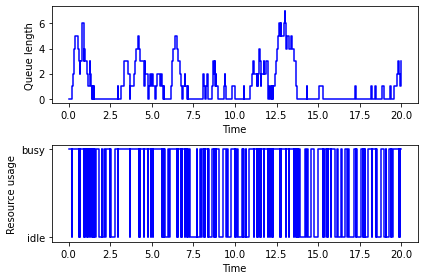

In [23]:
if PLOT_STATISTICS:
    import matplotlib.pyplot as plt
    x = []
    y = []
    z = []
    with open('/gdrive/My Drive/reneging_events-{:.3}-{:.3}-{}.csv'.format(ARRIVAL_RATE, SERVICE_RATE, RENEGING), 'r', newline='') as file:
        next(file)
        plots = csv.reader(file, delimiter = ',')

        for row in plots:
            if row[0].split('.')[0] == '100':
                break
            x.append(float(row[0]))
            y.append(int(row[3]))
            z.append(int(row[4]))
    plt.subplot(2, 1, 1)
    plt.xlabel('Time')
    plt.ylabel('Queue length')
    plt.step(x, y, 'b', where = 'post')
    plt.subplot(2, 1, 2)
    plt.xlabel('Time')
    plt.ylabel('Resource usage')
    plt.yticks([0, 1], ['idle', 'busy'])
    plt.step(x, z, 'b', where = 'post')
    plt.tight_layout()
    # plt.figure(figsize=(5, 2))
    plt.show()

2. Without Reneging

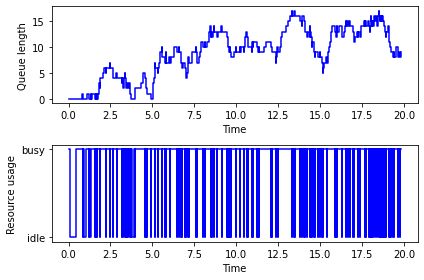

In [ ]:
if PLOT_STATISTICS:
    import matplotlib.pyplot as plt
    x = []
    y = []
    z = []
    with open('/gdrive/My Drive/without_reneging_events-{:.3}-{:.3}-{}.csv'.format(ARRIVAL_RATE, SERVICE_RATE, WITHOUT_RENEGING), 'r', newline='') as file:
        next(file)
        plots = csv.reader(file, delimiter = ',')

        for row in plots:
            if row[0].split('.')[0] == '100':
                break
            x.append(float(row[0]))
            y.append(int(row[3]))
            z.append(int(row[4]))
    plt.subplot(2, 1, 1)
    plt.xlabel('Time')
    plt.ylabel('Queue length')
    plt.step(x, y, 'b', where = 'post')
    plt.subplot(2, 1, 2)
    plt.xlabel('Time')
    plt.ylabel('Resource usage')
    plt.yticks([0, 1], ['idle', 'busy'])
    plt.step(x, z, 'b', where = 'post')
    plt.tight_layout()
    plt.show()